<h1>Programming Exercise 5:
    Regularized Linear Regression and Bias vs. Variance</h1>
    
<h3> Introduction </h3>
In this exercise, we will implement regularized linear regression and use it to study models with different bias-variance properties. To start, we will import necessary modules, implement some useful functions from previous exercises, and load our data.


In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [2]:
def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    """
    Trains linear regression using scipy's optimize.minimize.

    Parameters
    ----------
    X : array_like
        The dataset with shape (m x n+1). The bias term is assumed to be concatenated.

    y : array_like
        Function values at each datapoint. A vector of shape (m,).

    lambda_ : float, optional
        The regularization parameter.

    maxiter : int, optional
        Maximum number of iteration for the optimization algorithm.

    Returns
    -------
    theta : array_like
        The parameters for linear regression. This is a vector of shape (n+1,).
    """
    # Initialize Theta
    initial_theta = np.zeros(X.shape[1])

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return res.x

In [3]:
def featureNormalize(X):
    """
    Normalizes the features in X returns a normalized version of X where the mean value of each
    feature is 0 and the standard deviation is 1. This is often a good preprocessing step to do when
    working with learning algorithms.

    Parameters
    ----------
    X : array_like
        An dataset which is a (m x n) matrix, where m is the number of examples,
        and n is the number of dimensions for each example.

    Returns
    -------
    X_norm : array_like
        The normalized input dataset.

    mu : array_like
        A vector of size n corresponding to the mean for each dimension across all examples.

    sigma : array_like
        A vector of size n corresponding to the standard deviations for each dimension across
        all examples.
    """
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma

In [7]:
def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    """
    Plots a learned polynomial regression fit over an existing figure.
    Also works with linear regression.
    Plots the learned polynomial fit with power p and feature normalization (mu, sigma).

    Parameters
    ----------
    polyFeatures : func
        A function which generators polynomial features from a single feature.

    min_x : float
        The minimum value for the feature.

    max_x : float
        The maximum value for the feature.

    mu : float
        The mean feature value over the training dataset.

    sigma : float
        The feature standard deviation of the training dataset.

    theta : array_like
        The parameters for the trained polynomial linear regression.

    p : int
        The polynomial order.
    """
    # We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    # Plot
    plt.plot(x, np.dot(X_poly, theta), '--', lw=2)


<h3>1 Regularized Linear Regression</h3>
In the first half of this exercize, we will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. We begin by visualizing the dataset which is split into a training set (X,y), a cross validation set (Xval, yval), and a test set (Xtest, ytest)

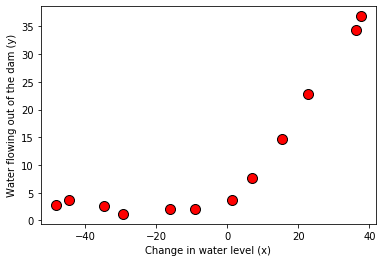

In [12]:
# Load from ex5data1.mat, where all variables will be store in a dictionary
data = loadmat(os.path.join('Data', 'ex5data1.mat'))

# Extract train, test, validation data from dictionary
# and also convert y's form 2-D matrix (MATLAB format) to a numpy vector
X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

# m = Number of examples
m = y.size

# Plot training data
plt.plot(X, y, 'ro', ms=10, mec='k', mew=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');

Next, we implement a regularized linear regression cost function.

In [13]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    """
    Compute cost and gradient for regularized linear regression 
    with multiple variables. Computes the cost of using theta as
    the parameter for linear regression to fit the data points in X and y. 
    
    Parameters
    ----------
    X : array_like
        The dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each datapoint. A vector of
        shape (m, ).
    
    theta : array_like
        The parameters for linear regression. A vector of shape (n+1,).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    J : float
        The computed cost function. 
    
    grad : array_like
        The value of the cost function gradient w.r.t theta. 
        A vector of shape (n+1, ).
    """
    # Initialize some useful values
    m = y.size # number of training examples
    J = 0
    grad = np.zeros(theta.shape)

    h = X.dot(theta)
    J = h-y
    J = np.square(J)
    J = np.sum(J)
    J = J / (2*m)
    tempTheta = theta[0]
    theta[0] = 0
    J += (lambda_/(2*m))*np.sum(np.sum(np.square(theta)))
    theta[0] = tempTheta
    
    grad = (1/m)*X.transpose().dot(h-y)
    grad[1:] += (lambda_/m)*theta[1:]
    
    return J, grad

In [14]:
# Test case for cost function

theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Cost at theta = [1, 1]:\t   %f ' % J)
print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))

Cost at theta = [1, 1]:	   303.993192 
Gradient at theta = [1, 1]:  [-15.303016, 598.250744] 


Next we run train our  linear regression model using this cost function and graph the resulting line of best fit.

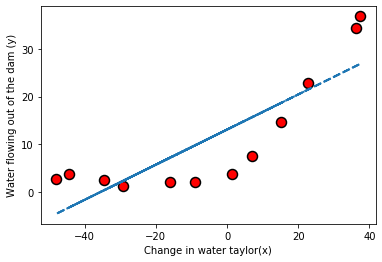

In [18]:
# add a columns of ones for the y-intercept
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
theta = trainLinearReg(linearRegCostFunction, X_aug, y, lambda_=0)

#  Plot fit over the data
plt.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
plt.xlabel('Change in water taylor(x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(X, np.dot(X_aug, theta), '--', lw=2);

<h3> 2 Bias-Variance</h3>
An important concept in machine learning is the bias-variance tradeoff. High bias models are not complex enough for the data and tend to underfit, while high variance models over fit the training data.

In this portion of the exercise we attempt to diagnose bias-variance problems by plotting training and test errors on a learning curve. 

We begin by creating a function to return a vector of errors for the training and cross validation set, then plotting it on a graph.

In [19]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    """
    Generates the train and cross validation set errors needed to plot a learning curve
    returns the train and cross validation set errors for a learning curve. 
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    error_train : array_like
        A vector of shape m. error_train[i] contains the training error for
        i examples.
    error_val : array_like
        A vecotr of shape m. error_val[i] contains the validation error for
        i training examples.
    """
    # Number of training examples
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    
    for i in range(1, m+1):
        X_train = X[:i, :]
        y_train = y[:i]
        Theta = trainLinearReg(linearRegCostFunction, X_train, y_train, lambda_=0.0, maxiter=200)
        error_train[i-1] = linearRegCostFunction(X_train,y_train,Theta,0)[0];
        error_val[i-1] = linearRegCostFunction(Xval,yval,Theta,0)[0];
        
    # =============================================================
    return error_train, error_val

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	205.121096
  	2		0.000000	110.302641
  	3		3.286595	45.010231
  	4		2.842678	48.368911
  	5		13.154049	35.865165
  	6		19.443963	33.829962
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


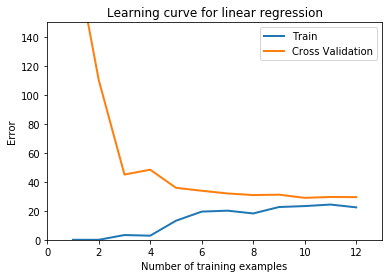

In [21]:
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)

plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 150])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

Looking at the resulting figure, we can see that both the taining and cross validation errors are high when the number of training examples is increase (specifically the training error increases to math cross validation). This reflects a problem of high bias in our model. That is to say, our model is too simple and unable to fit our data set well. 

<h3>3 Polynomial Regression</h3>
The problem with our model was that it was too simple for the data and resulted in underfitting (high bias). In this portion of the exercise, we will address this problem by adding more features to produce a more complex fit to the data. We begin by creating a function to map the original training set into its higher powers.

In [22]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    """
    X_poly = np.zeros((X.shape[0], p))
    X_poly[:,0] = X[:,0]
    for i in range(1,p):
        X_poly[:,i] = np.power(X.transpose(), i+1)

    return X_poly

We now apply this function to our training set, test set, and cross validation set.

In [23]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)


Now that we have the ability to map polynomial features, we can train our model via linear regression and plot to see how it fits our data. We will also plot a learning curve for lambda = 0 to see if we still have a  bias/variance problem.

Polynomial Regression (lambda = 0.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	160.721900
  	2		0.000000	160.121511
  	3		0.000000	59.071634
  	4		0.000000	77.997728
  	5		0.000000	6.448961
  	6		0.000000	10.831639
  	7		0.000000	27.916727
  	8		0.000064	21.128258
  	9		0.000147	30.474290
  	10		0.021425	50.335502
  	11		0.032329	55.153697
  	12		0.036300	37.781163


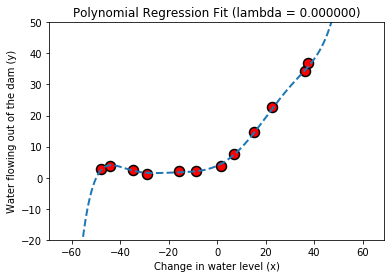

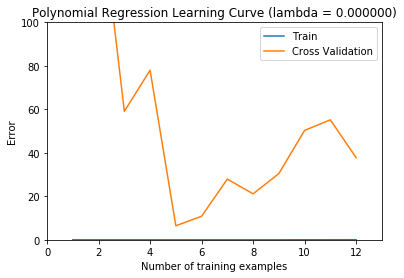

In [24]:
lambda_ = 0
theta = trainLinearReg(linearRegCostFunction, X_poly, y,
                             lambda_=lambda_, maxiter=55)

# Plot training data and fit
plt.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
plt.ylim([-20, 50])

plt.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
plt.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

plt.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 100])
plt.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

Looking at the resulting figures, we can see that our curve fits the data extremely well. In fact, it fits it too well. Along the samples it follows perfectly, however it fails to follow the trend along the extremes. We can also see this in the learning curve, as while the training error is extremely low, the cross validation error (the error we would realistically expect to see) is still high. This imply we now have an issue of high-variance, or overfitting.  To address this, we can add a regularization term. In order to choose an effective lambda, we automate the process by testing a sequence of lambdas and choosing the one with the least error.

In [25]:
def validationCurve(X, y, Xval, yval):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select lambda_.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n) where m is the 
        total number of training examples, and n is the number of features 
        including any polynomial features.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n) where m is the 
        total number of validation examples, and n is the number of features 
        including any polynomial features.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    Returns
    -------
    lambda_vec : list
        The values of the regularization parameters which were used in 
        cross validation.
    
    error_train : list
        The training error computed at each value for the regularization
        parameter.
    
    error_val : list
        The validation error computed at each value for the regularization
        parameter.
    """
    # Selected values of lambda
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    for i in range(len(lambda_vec)):
        lambda_ = lambda_vec[i]
        Theta = trainLinearReg(linearRegCostFunction, X, y, lambda_, maxiter=200)
        error_train[i] = linearRegCostFunction(X,y,Theta,0)[0]
        error_val[i] = linearRegCostFunction(Xval,yval,Theta,0)[0]

    return lambda_vec, error_train, error_val

We now plot a cross validation curve of error vs lambda which allows us to select which lambda paremeter to use.

In [26]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

NameError: name 'pyplot' is not defined

With this, we can see the optimal lambda would be around 3

(-20, 50)

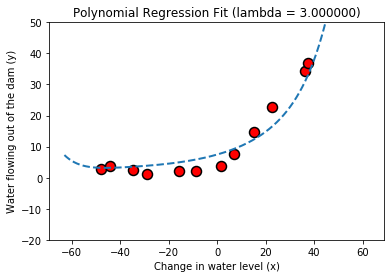

In [27]:
lambda_ = 3
theta = trainLinearReg(linearRegCostFunction, X_poly, y,
                             lambda_=lambda_, maxiter=55)

# Plot training data and fit
plt.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
plt.ylim([-20, 50])
